# 07 - Soil Classification Analysis

This notebook analyzes the relationship between earthquake characteristics and soil classification types.

## Soil Classes (TBDY 2018)
- **ZA**: Hard rock (Vs30 > 800 m/s)
- **ZB**: Soft rock (360-800 m/s)
- **ZC**: Dense soil (180-360 m/s)
- **ZD**: Soft soil (< 180 m/s)
- **ZE**: Very soft soil (special soils)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os, sys, warnings
warnings.filterwarnings('ignore')

sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), 'src'))
from config import *
from visualization import setup_style
setup_style()

OUTPUT_DIR = os.path.join(FIGURES_PATH, '07_soil')
os.makedirs(OUTPUT_DIR, exist_ok=True)

eq_df = pd.read_csv(os.path.join(DATA_PROCESSED, 'earthquakes_processed.csv'))
eq_df['date'] = pd.to_datetime(eq_df['date'], format='mixed')

print(f"Loaded {len(eq_df):,} records")
print(f"Records with soil data: {eq_df['soil_class'].notna().sum():,}")

Loaded 524,952 records
Records with soil data: 515,089


In [2]:
# Filter records with soil data
eq_soil = eq_df[eq_df['soil_class'].notna()].copy()

print("\nSoil Class Distribution:")
print(eq_soil['soil_class'].value_counts())


Soil Class Distribution:
soil_class
ZC    283216
ZB    186701
ZE     45172
Name: count, dtype: int64


In [3]:
# Statistics by soil class
soil_stats = eq_soil.groupby('soil_class').agg({
    'eventID': 'count',
    'magnitude': ['mean', 'std', 'max'],
    'depth': ['mean', 'std']
}).round(2)
soil_stats.columns = ['count', 'mag_mean', 'mag_std', 'mag_max', 'depth_mean', 'depth_std']
print("\nStatistics by Soil Class:")
soil_stats


Statistics by Soil Class:


,count,mag_mean,mag_std,mag_max,depth_mean,depth_std
soil_class,,,,,,
ZB,186701,1.97,0.73,7.0,7.78,3.37
ZC,283216,1.96,0.69,7.7,8.46,6.53
ZE,45172,2.05,0.69,7.4,7.81,3.92


Soil classes in data: ['ZB', 'ZC', 'ZE']


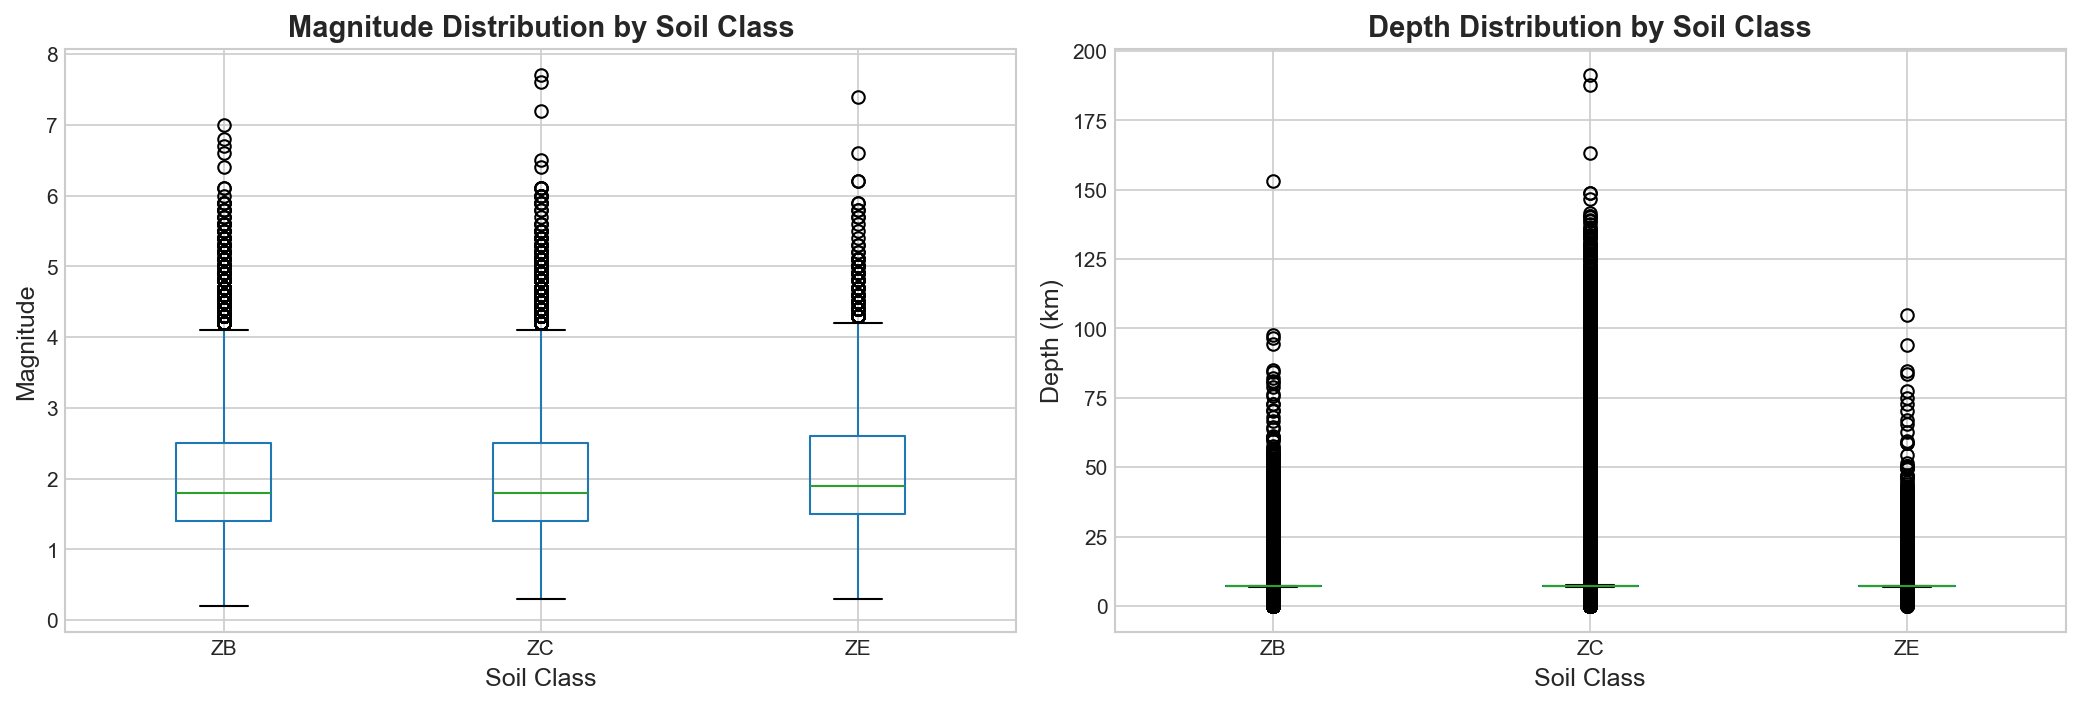

In [4]:
# Box plots by soil class
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Get actual soil classes present in data
actual_soil_classes = sorted(eq_soil['soil_class'].unique())
print(f"Soil classes in data: {actual_soil_classes}")

# Magnitude by soil class
ax1 = axes[0]
eq_soil.boxplot(column='magnitude', by='soil_class', ax=ax1)
ax1.set_xlabel('Soil Class')
ax1.set_ylabel('Magnitude')
ax1.set_title('Magnitude Distribution by Soil Class', fontweight='bold')
plt.suptitle('')

# Depth by soil class
ax2 = axes[1]
eq_soil.boxplot(column='depth', by='soil_class', ax=ax2)
ax2.set_xlabel('Soil Class')
ax2.set_ylabel('Depth (km)')
ax2.set_title('Depth Distribution by Soil Class', fontweight='bold')
plt.suptitle('')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'soil_boxplots.png'), dpi=150, bbox_inches='tight')
plt.show()

In [5]:
# ANOVA test for magnitude differences
actual_classes = sorted(eq_soil['soil_class'].unique())
groups = [eq_soil[eq_soil['soil_class'] == s]['magnitude'].values for s in actual_classes]
f_stat, p_value = stats.f_oneway(*groups)

print("\nANOVA Test (Magnitude by Soil Class):")
print(f"  F-statistic: {f_stat:.4f}")
print(f"  p-value: {p_value:.4e}")
print(f"  Result: {'Significant' if p_value < 0.05 else 'Not significant'} difference (α=0.05)")


ANOVA Test (Magnitude by Soil Class):
  F-statistic: 280.4048
  p-value: 1.9408e-122
  Result: Significant difference (α=0.05)


In [6]:
# Kruskal-Wallis test (non-parametric)
h_stat, p_value_kw = stats.kruskal(*groups)

print("\nKruskal-Wallis Test (Magnitude by Soil Class):")
print(f"  H-statistic: {h_stat:.4f}")
print(f"  p-value: {p_value_kw:.4e}")


Kruskal-Wallis Test (Magnitude by Soil Class):
  H-statistic: 656.4858
  p-value: 2.7920e-143


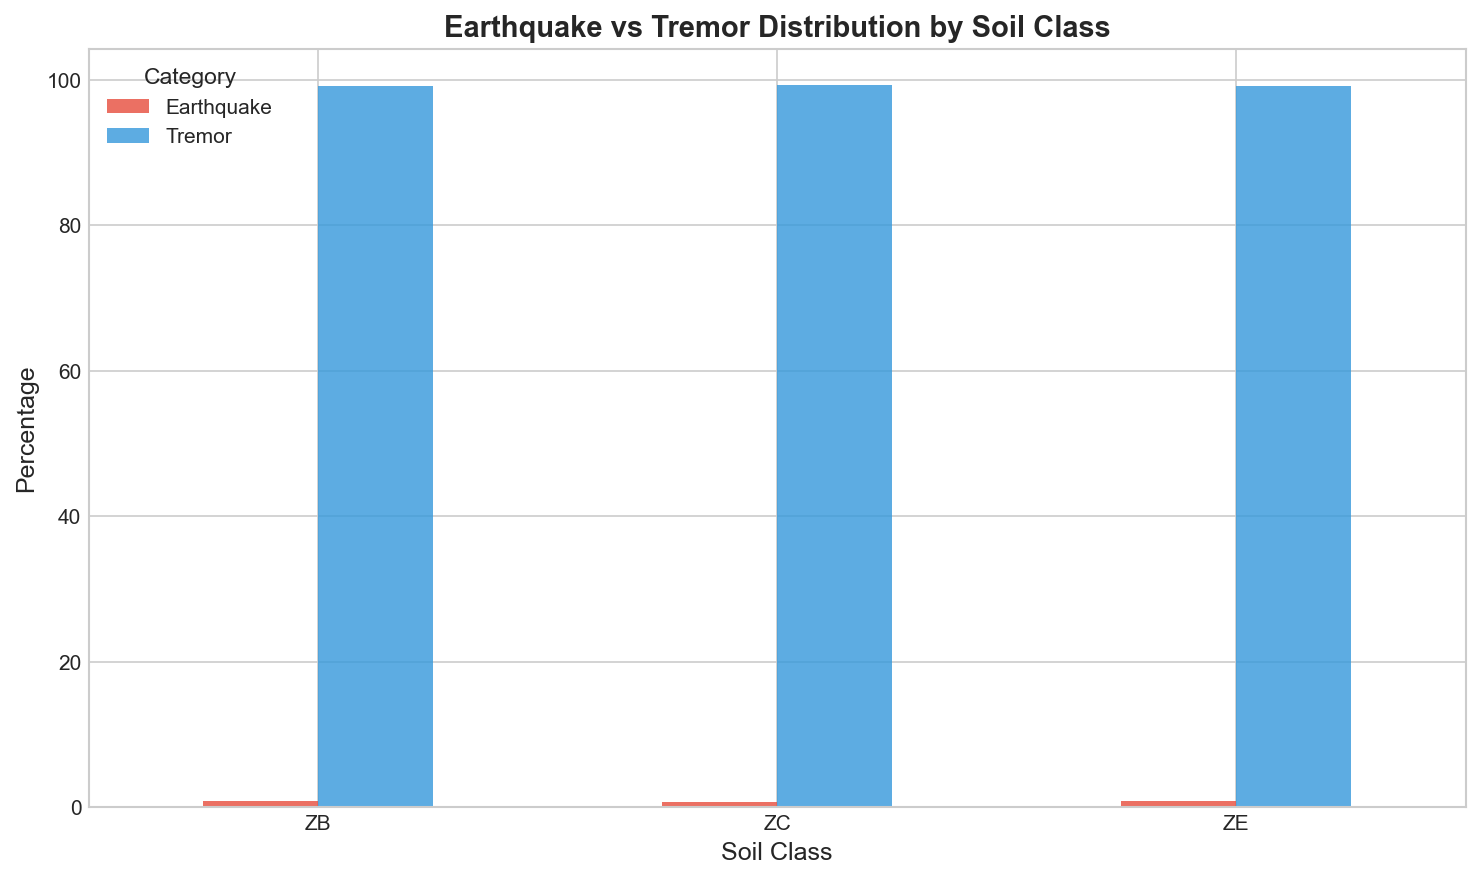

In [7]:
# Earthquake category distribution by soil class
cat_soil = pd.crosstab(eq_soil['soil_class'], eq_soil['category'], normalize='index') * 100

fig, ax = plt.subplots(figsize=(10, 6))
cat_soil.plot(kind='bar', ax=ax, color=[COLORS['earthquake'], COLORS['tremor']], alpha=0.8)
ax.set_xlabel('Soil Class')
ax.set_ylabel('Percentage')
ax.set_title('Earthquake vs Tremor Distribution by Soil Class', fontweight='bold')
ax.legend(title='Category')
plt.xticks(rotation=0)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'category_by_soil.png'), dpi=150, bbox_inches='tight')
plt.show()

In [8]:
# Chi-square test for independence
contingency = pd.crosstab(eq_soil['soil_class'], eq_soil['category'])
chi2, p_val, dof, expected = stats.chi2_contingency(contingency)

print("\nChi-square Test (Soil Class vs Category Independence):")
print(f"  Chi² = {chi2:.2f}")
print(f"  p-value = {p_val:.4e}")
print(f"  Degrees of freedom = {dof}")
print(f"  Result: {'Dependent' if p_val < 0.05 else 'Independent'} (α=0.05)")


Chi-square Test (Soil Class vs Category Independence):
  Chi² = 21.53
  p-value = 2.1169e-05
  Degrees of freedom = 2
  Result: Dependent (α=0.05)


In [9]:
# Save results
soil_stats.to_csv(os.path.join(TABLES_PATH, 'soil_analysis_results.csv'))
print(f"\nResults saved to: {os.path.join(TABLES_PATH, 'soil_analysis_results.csv')}")
print(f"Figures saved to: {OUTPUT_DIR}")


Results saved to: /Users/boraesen/Desktop/Semester 7/Stat495/stat495project/reports/tables/soil_analysis_results.csv
Figures saved to: /Users/boraesen/Desktop/Semester 7/Stat495/stat495project/reports/figures/07_soil
